Welcome to the "how to" of Markov Chain Monte Carlo using PYMC. A python software package allowing you to fit complex models with ease. 

## Case Study 1: Exponential Growth

We are going to establish an exponential model in this case study. The ODE and it's solution will be defined in the near future.  

First things first. Data! Pandas is the defacto python package for reading in data. It's also smart to handle any necessary data conversions during this step. You may not need to and that's just fine! It all depends on what you are looking for.

In [1]:
## Cell 1 ##

import pandas as pd
data = pd.read_csv("../../case_study_1/python/data/phaeocystis_control.csv")
time = data['times'].values
obs = data['cells'].values

Here is the first thing that needs to be done. We will setup the logistic ODE that will adapt to the data. To do this, you will use variables that PyMC gives you by 'default'. Let me explain. Note that in Cell 2 there are 3 parameters being passed in (y, t, params). You will also not see these variables being explicitly passed in this way anywhere. Here is what happens. When you create the ODE function in Cell 2, it gets passed to the the 'cell_model' in Cell 3. Now look to where the 'cell_model' is called in cell 4. There it passes priors into Y0 and theta. The connection is Y0 goes to y, and theta goes to params. The order you hand over the priors matters so call them in the correct order when creating the ODE equation. Be sure to keep this in mind and take note of the position of you priors when you pass them, and the indicies used in y and params to setup your variables and inital conditions!

**mum**: Growth Rate  
**y**: Initial Value

$$
\frac{dy}{dt} = \mu y
$$

In [2]:
## Cell 2 ##

def ode(y, t, params):
    mum = params[0]
    return [mum * y[0]]

Here is the model we spoke about earlier. Here is what goes into each variable.

**func**: the ODE function you just created  
**times**: the time steps from your data  
**n_states**: possible states count  
**n_theta**: Unique parameter count  
**t0**: inital time step (should almost always be 0)

In [3]:
## Cell 3 ##

import pymc as pm
cell_model = pm.ode.DifferentialEquation(
    func=ode,
    times=data['times'].values,
    n_states=1,
    n_theta=1,
    t0=0
)

c:\Users\Whisk\anaconda3\envs\MCMC_Modeling\Lib\site-packages\pytensor\link\c\cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(


Here is where we assign out priors. Choosing priors is an interesting combination of art and science. You have all kinds of options. Uniform, normal, lognormal, halfnormal. It all depends on what you need. For $\mu$ we chose a truncatednormal prior. This says, we believe there is a normal distribution about some **x**, however, it cannot be above **y** or below **z**. For **N0**, we chose a lognormal distribution. This says we believe our value is around some **x** given a normalesque strictly positive distribution. For **sigma**, we chose a halfnormal distribution. This is usually used for your error or standard deviation. This is saying we know we can not have negative error, and we believe the error will be closer to 0 than farther away, however, we are not explicitly capping it off in the positive direction.

<img src="priors_c1p1.png" width="300"/>

Next is getting the current ODE results. We spoke about how to pass the priors in previously. Be careful during this step!

The final function is the Likelihood of the model. This is where we see how well the model results estimatied the data.

We name the random variable 'y_obs'.

For $\mu$, this is a bit complicated so we'll break this down.  
- y_hat[:,0] pulls the predicited trajectory for live cells from the ODE solution, note it's position in y_hat matches it's priors position when passed to cell_model.   
- pm.math.log() puts predictions on a log scale which matches the log transformed observed data. 

Sigma: The prior you just created for it! Simple.  
Observered: The true cell data you read in earlier.

In [4]:
## Cell 4 ##

import numpy as np
with pm.Model() as model:
    mum = pm.TruncatedNormal('mum', mu=0.5, sigma=0.3, lower=0.0, upper=1.0)
    N0 = pm.Lognormal('N0', mu=np.log(obs[0]), sigma=0.1)
    sigma = pm.HalfNormal("sigma", 1)

    y_hat = cell_model(y0=[N0], theta=[mum])
    pm.Normal("Y_obs", 
              mu=pm.math.log(y_hat[:, 0]), 
              sigma=sigma, 
              observed=np.log(obs))

When you are finally ready to run the model you will do so in the form shown between the '''. Here are what the variables being passed into pm.sample mean.

**draws**: poterior values to be generated.  
**tune**: Some under the hood PyMC magic that 'warms it up'. Keep this between 500 and 2000 depending on how complex your model is.  
**chains / cores**: Amount of chains you want to compute in parallel. Keep these values the same for most basic usage.  
**return_inferencedata**: returns an ARVIZ inferencedata object which we'll use for easy reading of our output.
**target_accept**: the % of times you accept the improved likelihood at each step of the chain. This is your exploration vs exploitation balance.

To save time, we are just going to read in the pre-computed **trace** and print so you can see the output. We will use ARVIZ and Matplotlib to do so. 

In [ ]:
## CELL 5 ##

'''
with model:
    trace = pm.sample(draws=1000, tune=1000, target_accept=0.95, chains=4, return_inferencedata=True)
'''
import arviz as az
import matplotlib.pyplot as plt

trace = az.from_netcdf("case_study_1_p1_trace.nc")

Sampling: [N0, Y_obs, mum, sigma]


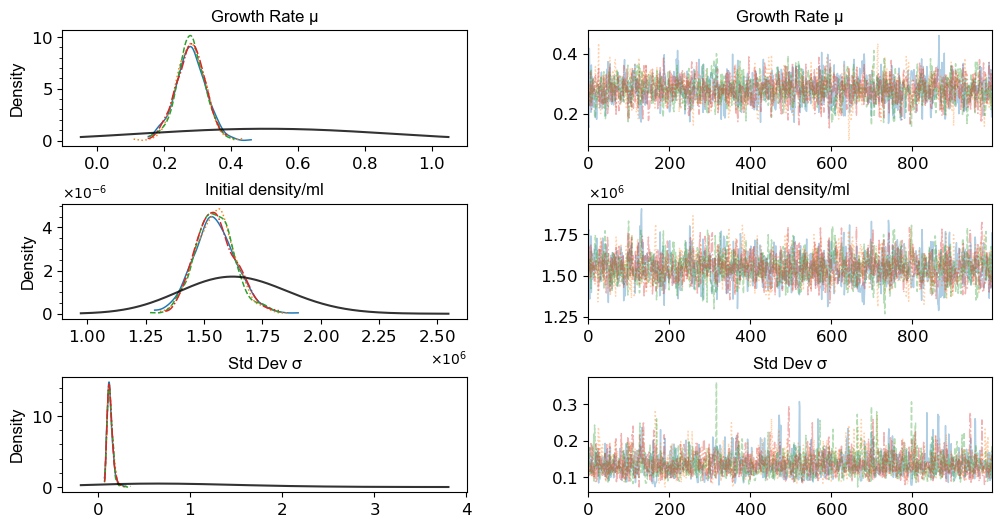

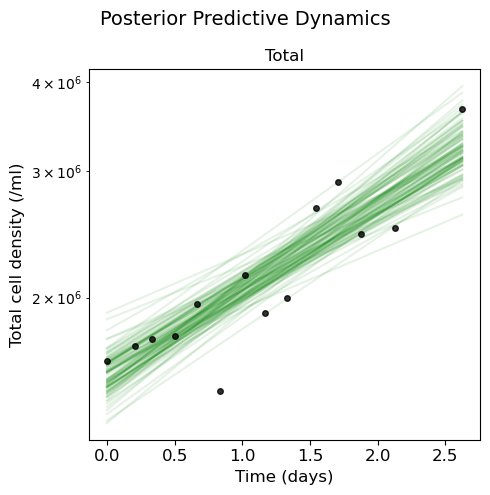

(<Figure size 500x500 with 1 Axes>,
 [<Axes: title={'center': 'Total'}, xlabel='Time (days)', ylabel='Total cell density (/ml)'>])

In [ ]:
import sys
sys.path.insert(0, "../..")
from utils.plot_utils_v2 import *

plot_trace(
trace=trace,
model=model,
var_names_map={'N0':'Initial density/ml','mum': 'Growth Rate μ', 'sigma': 'Std Dev σ'},
var_order=['mum','N0','sigma'],
fontname='Arial',
fontsize=12,
num_prior_samples=2000,
save_path='figures/normal_growth_chains.png'
)

## dataset
dataset_postprocessing = {
"Cells": [
        {"time": time, "values": obs},  # replicate 1
    ]
}

def ode_solution2data(solution):
    total = solution[:, 0]  # Assuming the first column is the total cell count
    return {
        "total": total
    }

posterior_dynamics(
dataset=dataset_postprocessing,
trace=trace,
model=model,
n_plots=100,
burn_in=50,
num_variables=1,
ode_fn=ode,
ode2data_fn=ode_solution2data,
save_path="figures/vardi_logistic_growth_dynamics.png",
# the key of this dict is the variable name in the dataset_postprocessing
var_properties={
    "Cells": {"label": "Total", "color": "black", "ylabel": "Total cell density (/ml)", "xlabel":"Time (days)","sol_key": "total","log": True}
},
suptitle="Posterior Predictive Dynamics",
color_lines='green'
)

Now we interpret the results. Remember the ODE's from before.

$$
\frac{dy}{dt} = \mu y
$$

Take note of x-axis values at the peaks of the PDFs and the variables they represent. The x-axis values at those peaks are what the model found to be the optimal value for the equation. The right hand column is a frequency plot. This is just to make sure the model is exploring the parameter space well enough. 

**CONGRATULATIONS!** you just ran you first MCMC!

## Case Study 1: Exponential Growth and Death

Now on to a more complex model. We will be using the same data as before.


In [11]:
## Cell 6 ##

import pandas as pd
data = pd.read_csv("../../case_study_1/python/data/phaeocystis_control.csv")
time = data['times'].values
obs = data['cells'].values

$$
\frac{dy}{dt} = (\mu - \delta)\, y
$$

Here we are simply subtracting a **delta** from **mu** so that **delta** can simulate death. In short, we don't always need death (or something else comperable) data. We can simply make our ODE expressive about the data!

In [12]:
## Cell 7 ##

def ode(y, t, params):
    mum,delta = params[0],params[1]
    return [(mum-delta) * y[0]]

Here we have our new model setup. We have two unique parameters (mum, delta) so we'll set **n_theta** to 2.

In [13]:
## Cell 8 ##

import pymc as pm
cell_model = pm.ode.DifferentialEquation(
    func=ode,
    times=data['times'].values,
    n_states=1,
    n_theta=2,
    t0=0
)

Here is the model. Everything here should make sense. If something is confusing see the explination above cell 4. Still note that we have two likelihoods at the bottom since we are estimating two states.

In [14]:
## Cell 9 ##

import numpy as np
with pm.Model() as model:
    mum = pm.TruncatedNormal('mum', mu=0.5, sigma=0.3, lower=0.0, upper=1.0)
    delta = pm.TruncatedNormal('delta', mu=0.5, sigma=0.3, lower=0.0, upper=1.0)
    N0 = pm.Lognormal('N0', mu=np.log(obs[0]), sigma=0.1)
    sigma = pm.HalfNormal("sigma", 1)

    y_hat = cell_model(y0=[N0], theta=[mum, delta])
    pm.Normal("Y_obs", mu=pm.math.log(y_hat[:, 0]), sigma=sigma, observed=np.log(obs))

Everything here is the same as before! See explination above cell 5 if you forgot something.

In [ ]:
## Cell 10 ##

'''
with model:
    trace = pm.sample(draws=1000, tune=1000, target_accept=0.95, chains=4, return_inferencedata=True)
'''
import arviz as az
import matplotlib.pyplot as plt

trace = az.from_netcdf("case_study_1_p2_trace.nc")

Sampling: [N0, Y_obs, delta, mum, sigma]


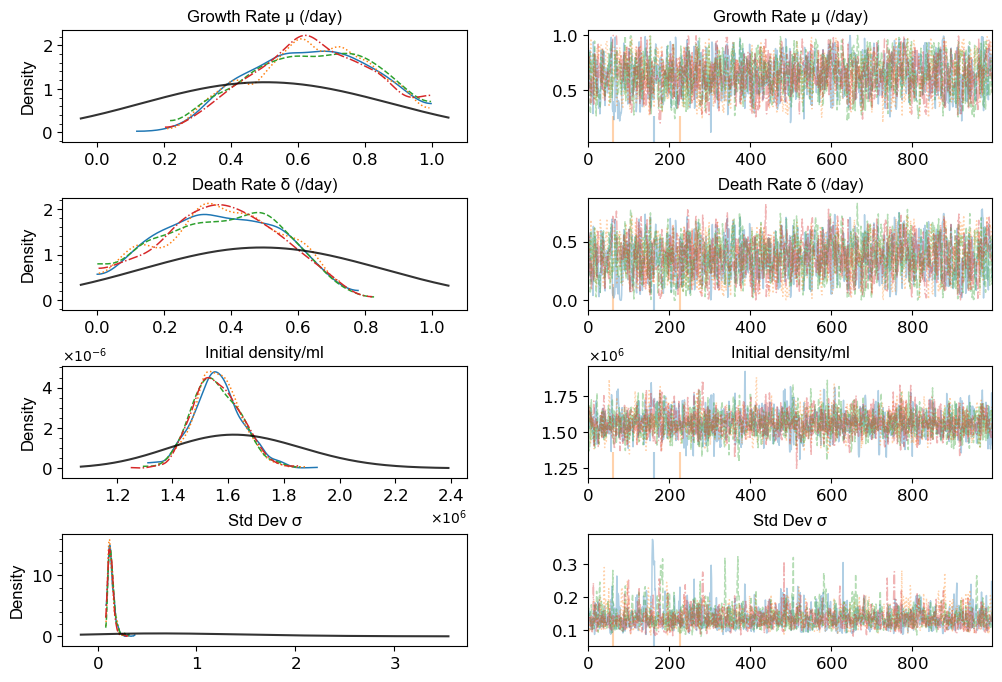

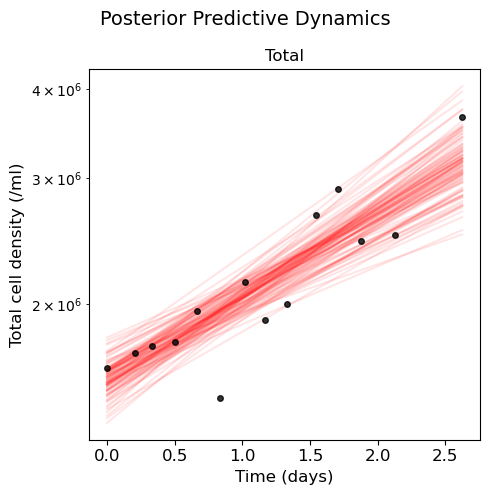

(<Figure size 500x500 with 1 Axes>,
 [<Axes: title={'center': 'Total'}, xlabel='Time (days)', ylabel='Total cell density (/ml)'>])

In [ ]:
plot_trace(
trace=trace,
model=model,
var_names_map={'N0':'Initial density/ml','mum': 'Growth Rate μ (/day)', 'delta': 'Death Rate δ (/day)','sigma': 'Std Dev σ'},
var_order=['mum','delta','N0','sigma'],
fontname='Arial',
fontsize=12,
num_prior_samples=2000,
save_path='figures/normal_growthdeath_chains.png'
)

dataset_postprocessing = {
"Cells": [
        {"time": time, "values": obs},  # replicate 1
    ]
}

def ode_solution2data(solution):    
    total = solution[:, 0]  # Assuming the first column is the total cell count
    return {
        "total": total
    }

posterior_dynamics(
dataset=dataset_postprocessing,
trace=trace,
model=model,
n_plots=100,
burn_in=50,
num_variables=1,
ode_fn=ode,
ode2data_fn=ode_solution2data,
save_path="figures/vardi_logistic_growthdeath_dynamics.png",
# the key of this dict is the variable name in the dataset_postprocessing
var_properties={
    "Cells": {"label": "Total", "color": "black", "ylabel": "Total cell density (/ml)", "xlabel":"Time (days)","sol_key": "total","log": True}
},
suptitle="Posterior Predictive Dynamics",
color_lines='red'
)

## The End